# Tomato Disease Classification with VGG 16 and Neural Network

# Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip /content/gdrive/MyDrive/Omdena_Green_Algeria_Chapter_Part_2/Tomato_dataset.zip > /dev/null

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Load Data


In [4]:
os.chdir("/content/Tomato_dataset")
print(os.listdir())

TRAINING_DIR = os.path.join('/content/Tomato_dataset/train')
VALIDATION_DIR = os.path.join('/content/Tomato_dataset/val')
TESTING_DIR = os.path.join('/content/Tomato_dataset/test')

['val', 'test', 'train']


In [5]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 8715 files belonging to 10 classes.


In [7]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2902 files belonging to 10 classes.


In [8]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           shuffle=False,
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           image_size=IMG_SIZE)

Found 2914 files belonging to 10 classes.


In [9]:
class_names = train_dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'Two_spotted_spider_mite']

# Visualize Training Data for each Class

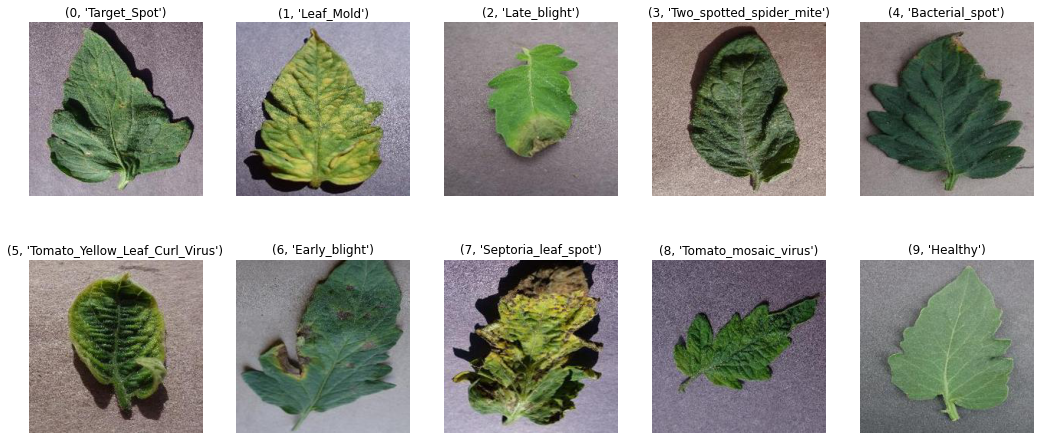

In [10]:
classes = os.listdir('./train')

plt.figure(figsize=(18,8))

for i in enumerate(classes):
    pic = os.listdir('./train/'+i[1])[0]
    image = Image.open('./train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i[0]+1)
    plt.title(i)
    plt.imshow(image)
    plt.axis("off")
plt.show()

# Data Summary

In [11]:
categories = []
train = []
val = []
test = []

folders = os.listdir('/content/Tomato_dataset/train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('/content/Tomato_dataset/train', f))))

folders = os.listdir('/content/Tomato_dataset/val')
for f in folders:
    val.append(len(os.listdir(os.path.join('/content/Tomato_dataset/val', f))))

folders = os.listdir('/content/Tomato_dataset/val')
for f in folders:
    test.append(len(os.listdir(os.path.join('/content/Tomato_dataset/test', f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test                     
                    })

data_count

,categories,train,val,test
0,Target_Spot,674,224,226
1,Leaf_Mold,457,152,153
2,Late_blight,916,305,307
3,Two_spotted_spider_mite,804,268,269
4,Bacterial_spot,1021,340,341
5,Tomato_Yellow_Leaf_Curl_Virus,2571,857,858
6,Early_blight,480,160,160
7,Septoria_leaf_spot,850,283,284
8,Tomato_mosaic_virus,179,59,61
9,Healthy,763,254,255


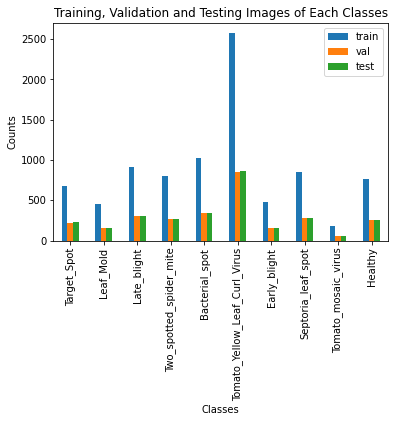

In [12]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

In [13]:
# Configure the dataset for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [14]:
def data_augmentation(x):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])(x)

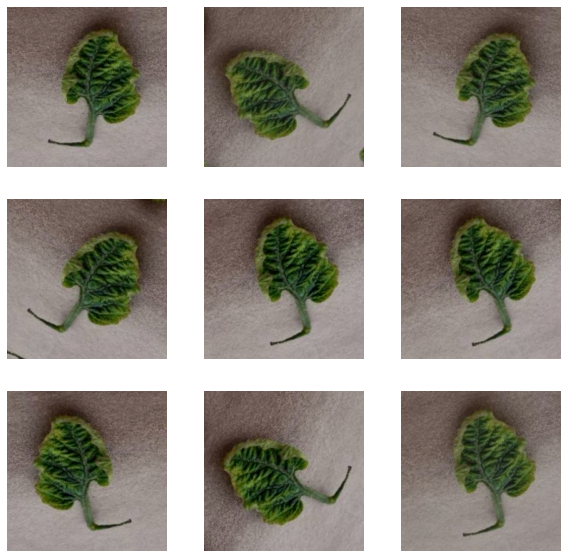

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Feature Extractor Base

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [17]:
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Utility Functions

In [18]:
def preprocess_input(x): 
    return tf.keras.layers.Rescaling(1./255, offset=-1)(x)


def feature_extractor(x):
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    return x


def classifier(x):
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x


def prediction_layer(x):
    return tf.keras.layers.Dense(10, activation='softmax')(x)

# Add Classification Head

In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x)
x = classifier(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

# Compile the Model

In [20]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [22]:
initial_epochs = 10

In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


273/273 [==============================] - 113s 369ms/step - loss: 2.0872 - accuracy: 0.2897 - val_loss: 1.9106 - val_accuracy: 0.3232
Epoch 2/10
273/273 [==============================] - 95s 347ms/step - loss: 1.8626 - accuracy: 0.3594 - val_loss: 1.6165 - val_accuracy: 0.5162
Epoch 3/10
273/273 [==============================] - 95s 346ms/step - loss: 1.6573 - accuracy: 0.4378 - val_loss: 1.4303 - val_accuracy: 0.5489
Epoch 4/10
273/273 [==============================] - 95s 347ms/step - loss: 1.5318 - accuracy: 0.4842 - val_loss: 1.3409 - val_accuracy: 0.5813
Epoch 5/10
273/273 [==============================] - 94s 345ms/step - loss: 1.4401 - accuracy: 0.5122 - val_loss: 1.2353 - val_accuracy: 0.6061
Epoch 6/10
273/273 [==============================] - 95s 348ms/step - loss: 1.3483 - accuracy: 0.5479 - val_loss: 1.1323 - val_accuracy: 0.6458
Epoch 7/10
273/273 [==============================] - 94s 343ms/step - loss: 1.2932 - accuracy: 0.5622 - val_loss: 1.0769 - val_accuracy: 0.

# Plot Learning Curves

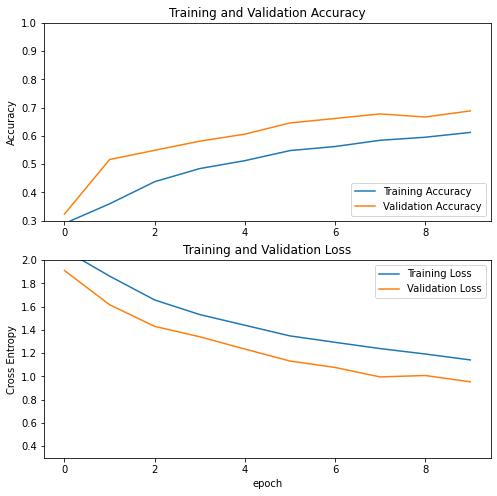

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.3,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.3,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Unfreeeze Some Layers of Feature Extractor

In [25]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 10

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


# Compile the Model

In [26]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

# Add Callbacks

In [28]:
os.getcwd()

'/content/Tomato_dataset'

In [29]:
os.chdir("/content")

checkpoint = ModelCheckpoint('./vgg16_NN.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
log_csv = CSVLogger('./vgg16_NN_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

# Continue Model Training

In [30]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callbacks_list)

Epoch 10/110


273/273 [==============================] - ETA: 0s - loss: 0.8553 - accuracy: 0.7095
Epoch 10: val_loss improved from inf to 0.60354, saving model to ./vgg16_NN.hdf5
273/273 [==============================] - 120s 422ms/step - loss: 0.8553 - accuracy: 0.7095 - val_loss: 0.6035 - val_accuracy: 0.7981
Epoch 11/110
273/273 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.7851
Epoch 11: val_loss improved from 0.60354 to 0.44238, saving model to ./vgg16_NN.hdf5
273/273 [==============================] - 116s 422ms/step - loss: 0.6098 - accuracy: 0.7851 - val_loss: 0.4424 - val_accuracy: 0.8470
Epoch 12/110
273/273 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.8313
Epoch 12: val_loss improved from 0.44238 to 0.35875, saving model to ./vgg16_NN.hdf5
273/273 [==============================] - 114s 417ms/step - loss: 0.4840 - accuracy: 0.8313 - val_loss: 0.3587 - val_accuracy: 0.8822
Epoch 13/110
273/273 [==============================] - ETA: 0s

# Plot Learning Curve 

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

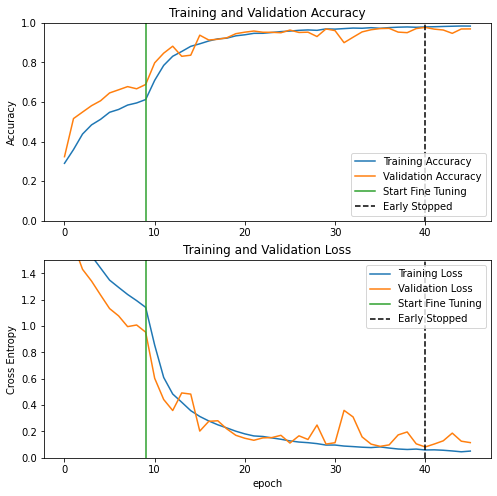

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

In [33]:
os.chdir("/content/Tomato_dataset")

CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    CLASSES.append(f)
    
CLASSES

['Target_Spot',
 'Leaf_Mold',
 'Late_blight',
 'Two_spotted_spider_mite',
 'Bacterial_spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Early_blight',
 'Septoria_leaf_spot',
 'Tomato_mosaic_virus',
 'Healthy']

# Prediction and Evaluation

In [34]:
predictions = np.array([])
labels =  np.array([])

for x, y in test_dataset:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 1s 868ms/step


Evaluating the Algorithm

Accuracy: 		 0.9694577899794098
Precision: 		 0.9706657634800882
Recall: 		 0.9694577899794098
F1 score: 		 0.9694577899794098 



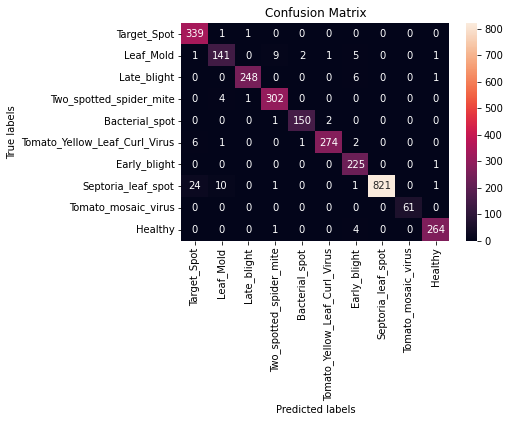

In [35]:
print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(labels, predictions))
print('Precision: \t\t', precision_score(labels, predictions, average='weighted'))
print('Recall: \t\t', recall_score(labels, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(labels, predictions, average='micro'), '\n')

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);

ax.set_title('Confusion Matrix'); 

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.xaxis.set_ticklabels(CLASSES); 
ax.yaxis.set_ticklabels(CLASSES);

plt.xticks(rotation = 90)
plt.yticks(rotation = 360)

plt.show()

In [36]:
# from google.colab import files
# files.download("/content/vgg16_NN.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# files.download("/content/vgg16_NN_logs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>